## Load the dependencies and configurations

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.configs import configs
configs

{'img_glob': '*.tif',
 'seg_glob': '*.npy',
 'default_output_directory_name': 'protein_localization_analysis',
 'tracking_features': ['centroid',
  'area',
  'major_axis_length',
  'minor_axis_length',
  'perimeter',
  'solidity',
  'moments_central'],
 'tracking_search_radius': 60,
 'node_dilations': 5,
 'edge_dilations': 4,
 'cyto_mask_erode_steps': 10,
 'cyto_mask_erode_footprint': <function skimage.morphology.footprints.square(width, dtype=<class 'numpy.uint8'>, *, decomposition=None)>,
 'dx_microns': None,
 'dy_microns': None,
 'dt_seconds': None,
 'n_processes': 1}

In [2]:
# these are needed to properly store and recover junction coordinates in Pandas dataframes
pd.set_option('display.max_colwidth', int(1e6))
np.set_printoptions(threshold=sys.maxsize)

## Load data (intensity images and segmentations)

In [3]:
from src.dataloaders import load_data

loader_inputs = {
    'channel_1_dirpath': './data/registered time points#8-1_R',
    'channel_2_dirpath': './data/registered time points#8-1_G',
    'seg_channel': 0,
    'img_glob':'*.tif',
    'seg_glob':'*.npy',
    'merge_channels': True,
}

data = load_data(**loader_inputs)

if loader_inputs['merge_channels']:
    print('img: {}, seg:{}'.format(data['img'].shape, data['seg'].shape))
else:
    print('img: {}, seg:{}'.format([arr.shape for arr in data['img'].values()], data['seg'].shape))

img: (2, 28, 467, 489), seg:(1, 28, 467, 489)


## Build cell outline networks (test)

In [4]:
from src.tissue_network import TissueNetwork

test_channel = 0
test_timepoint = 0
seg_channel = loader_inputs['seg_channel']

sample_img = data['img'][test_channel][test_timepoint]
sample_seg = data['seg'][seg_channel][test_timepoint]

tissue_network = TissueNetwork(sample_seg)
network = tissue_network.build()

network.keys()

100%|██████████| 210/210 [00:00<00:00, 29663.69it/s]


dict_keys(['skeleton', 'graph', 'edge_labels', 'node_labels'])

## Visualize cell outline networks

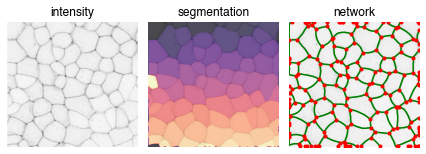

In [5]:
fig, ax = plt.subplots(ncols=3)

ax[0].imshow(sample_img, cmap='gray_r')
ax[1].imshow(sample_img, cmap='gray_r')
ax[1].imshow(sample_seg, cmap='magma', alpha=0.7, zorder=10)
ax[2].imshow(sample_img, cmap='gray_r')

_graph = network['graph']

# draw edges by pts
for (s,e) in _graph.edges():
    ps = _graph[s][e]['pts']
    ax[2].plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = _graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
ax[2].plot(ps[:,1], ps[:,0], 'r.')

ax[0].set_title('intensity')
ax[1].set_title('segmentation')
ax[2].set_title('network')

for axi in ax: axi.axis('off')
fig.tight_layout(pad=1)
fig.savefig('assets/sample_pipeline.png', dpi=300, bbox_inches='tight')

## Run cyto analyzer (all cells and all times)

In [6]:
from src.cells import tabulate_cells, CytoAnalyzer

cyto_analyzer = CytoAnalyzer(imgs=data['img'], seg_masks=data['seg'])

cells_tables = cyto_analyzer.run()

CytoAnalyzer started with imgs: (2, 28, 467, 489) and seg masks: (1, 28, 467, 489)


Generating cytoplasmic masks...: 100%|##########| 28/28 [00:37<00:00,  1.35s/it]


## Run junctions analyzer (bi- and multi-cellular junctions; all cells and all times)

### Create the cell networks in prep for cell-cell junctions analysis

In [7]:
from src.junctions import JunctionsAnalyzer

junctions_analyzer = JunctionsAnalyzer(imgs=data['img'], seg_masks=data['seg'])
junctions_analyzer.generate_networks()

generating networks...: 100%|##########| 28/28 [00:42<00:00,  1.54s/it]


### Analyze the bi-cellular junctions

In [8]:
edge_tables = junctions_analyzer.tabulate_edges()

Analyzing bicellular junctions in frame 0...: 210it [00:07, 27.99it/s]t/s]
Analyzing bicellular junctions in frame 1...: 216it [00:07, 28.43it/s],  7.52s/it]
Analyzing bicellular junctions in frame 2...: 206it [00:07, 28.53it/s],  7.57s/it]
Analyzing bicellular junctions in frame 3...: 209it [00:07, 28.39it/s],  7.41s/it]
Analyzing bicellular junctions in frame 4...: 208it [00:07, 28.55it/s],  7.39s/it]
Analyzing bicellular junctions in frame 5...: 216it [00:07, 28.44it/s],  7.35s/it]
Analyzing bicellular junctions in frame 6...: 224it [00:07, 28.16it/s],  7.44s/it]
Analyzing bicellular junctions in frame 7...: 232it [00:08, 28.14it/s],  7.61s/it]
Analyzing bicellular junctions in frame 8...: 236it [00:08, 28.37it/s],  7.81s/it]
Analyzing bicellular junctions in frame 9...: 244it [00:08, 28.54it/s],  7.97s/it]
Analyzing bicellular junctions in frame 10...: 249it [00:08, 28.62it/s],  8.15s/it]
Analyzing bicellular junctions in frame 11...: 259it [00:08, 28.79it/s],  8.32s/it]
Analyzing 

### Analyze the multi-cellular junctions

In [9]:
node_tables = junctions_analyzer.tabulate_nodes()

Analyzing multicellular junctions in frame 0...: 210it [00:07, 27.11it/s]t/s]
Analyzing multicellular junctions in frame 1...: 216it [00:07, 27.24it/s],  7.75s/it]
Analyzing multicellular junctions in frame 2...: 206it [00:07, 26.45it/s],  7.86s/it]
Analyzing multicellular junctions in frame 3...: 209it [00:07, 26.29it/s],  7.83s/it]
Analyzing multicellular junctions in frame 4...: 208it [00:07, 27.14it/s],  7.88s/it]
Analyzing multicellular junctions in frame 5...: 216it [00:08, 25.72it/s],  7.80s/it]
Analyzing multicellular junctions in frame 6...: 224it [00:08, 26.03it/s],  8.00s/it]
Analyzing multicellular junctions in frame 7...: 232it [00:08, 26.35it/s],  8.20s/it]
Analyzing multicellular junctions in frame 8...: 236it [00:08, 27.04it/s],  8.39s/it]
Analyzing multicellular junctions in frame 9...: 244it [00:09, 26.45it/s],  8.50s/it]
Analyzing multicellular junctions in frame 10...: 249it [00:09, 26.54it/s],  8.72s/it]
Analyzing multicellular junctions in frame 11...: 259it [00:0

## Visualize cell morphology measurements

Drawing cell orientations...: 100%|##########| 1/1 [00:00<00:00,  1.33it/s]


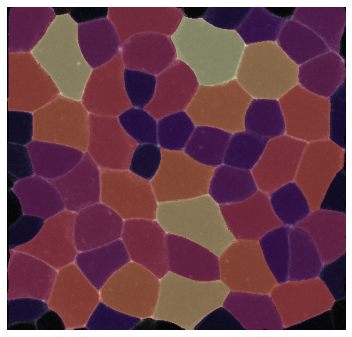

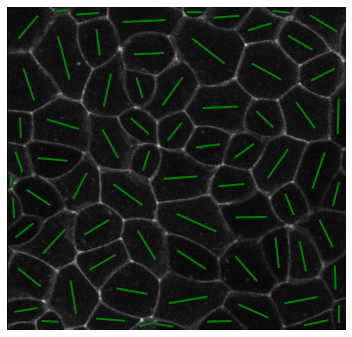

In [10]:
from src.visualization import TissuePlotter

# the visualizer requires the channel and time axes
_img = sample_img[np.newaxis, np.newaxis, ...]
_seg = sample_seg[np.newaxis, np.newaxis, ...]

plotter = TissuePlotter(_img, _seg)
plotter.plot(field='area', channel=0, savedir='./output', display=True )
plotter.plot(field='orientation', channel=0, savedir='./output', display=True )